# <span style="color:#4174B9">Baseball Statistics</span>

Baseball statistics play an important role in evaluating a player's and/or team's progress. Since the flow of a baseball game has natural breaks to it, and normally players act individually rather than performing in clusters, the sport lends itself to easy record-keeping and statistics. Statistics have been kept for professional baseball since the creation of the National League and American League, now part of Major League Baseball.

The following analysis is based on baseball data made available by Sean Lahman, an award-winning database journalist and author. The data can be downloaded from this [link](http://www.seanlahman.com/baseball-archive/statistics/). Let's start by asking a question.

## <span style="color:#0C856D">1. Which baseball statistics do the managers look at while assessing a player?</span>
In order to find answer to this question, let us look at the distribution of salaries of players and how they relate with team wins.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
%pylab inline
sns.set_style('white')
pd.options.display.max_rows = 8
pd.options.display.max_columns = 15

Populating the interactive namespace from numpy and matplotlib


In [2]:
def read_csv(filename):
    path = './baseballdatabank-master/core/'
    data = pd.read_csv(path + filename, sep=',', keep_default_na=False, na_values=[''])
    print filename, 'has', data.shape[0], 'rows and', data.shape[1], 'columns'
    return data

In [3]:
salaries = read_csv('Salaries.csv')

Salaries.csv has 25575 rows and 5 columns


In [4]:
salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25575 entries, 0 to 25574
Data columns (total 5 columns):
yearID      25575 non-null int64
teamID      25575 non-null object
lgID        25575 non-null object
playerID    25575 non-null object
salary      25575 non-null int64
dtypes: int64(2), object(3)
memory usage: 999.1+ KB


In [5]:
# Format salary labels to make them concise (round off to nearest millions)
def millions(x, pos):
    # The two args are the value and tick position
    return '$%1.1fM' % (x*1e-6)

formatter = FuncFormatter(millions)

/home/prabhu/anaconda3/envs/py2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


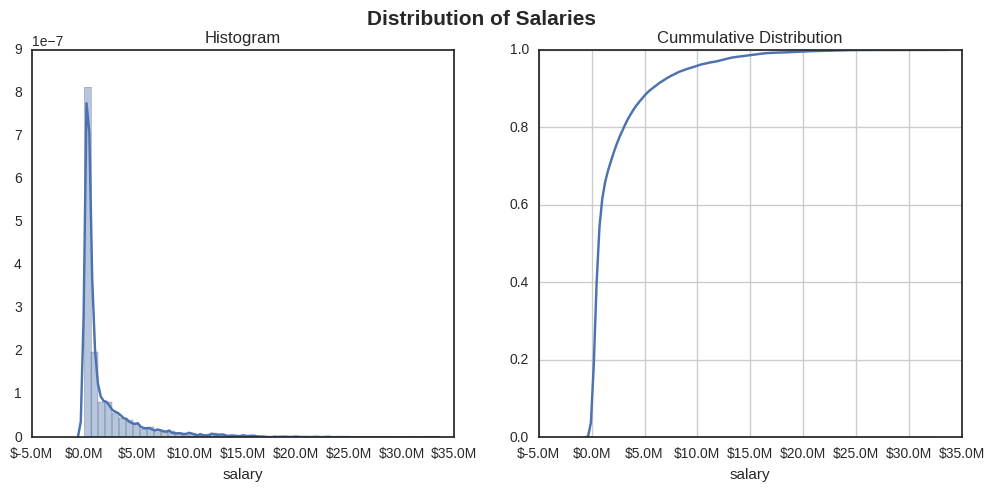

In [6]:
f, ax = plt.subplots(nrows=1, ncols=2)
f.set_size_inches((12,5))
f.suptitle("Distribution of Salaries", fontsize=15, weight='bold')

p1 = sns.distplot(salaries['salary'], ax=ax[0])
p1.xaxis.set_major_formatter(formatter)
p1.set_title("Histogram")

p2 = sns.distplot(salaries['salary'], kde_kws=dict(cumulative=True), ax=ax[1])
p2.xaxis.set_major_formatter(formatter)
p2.set_title("Cummulative Distribution")
p2.grid()

In [7]:
teams = read_csv('Teams.csv')

Teams.csv has 2805 rows and 48 columns


In [8]:
teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2805 entries, 0 to 2804
Data columns (total 48 columns):
yearID            2805 non-null int64
lgID              2805 non-null object
teamID            2805 non-null object
franchID          2805 non-null object
divID             1288 non-null object
Rank              2805 non-null int64
G                 2805 non-null int64
Ghome             2406 non-null float64
W                 2805 non-null int64
L                 2805 non-null int64
DivWin            1260 non-null object
WCWin             624 non-null object
LgWin             2777 non-null object
WSWin             2448 non-null object
R                 2805 non-null int64
AB                2805 non-null int64
H                 2805 non-null int64
2B                2805 non-null int64
3B                2805 non-null int64
HR                2805 non-null int64
BB                2805 non-null int64
SO                2685 non-null float64
SB                2661 non-null float64
CS    

In [9]:
avg_yearly_salary = salaries.groupby('teamID').mean()['salary']
avg_yearly_wins = teams.groupby('teamID').mean()['W']
wins_vs_salary = pd.concat([avg_yearly_wins, avg_yearly_salary], axis=1)
wins_vs_salary

,W,salary
ALT,6.000000,NaN
ANA,83.000000,1.895109e+06
ARI,79.666667,2.479160e+06
ATL,82.120000,2.206239e+06
...,...,...
WS7,12.000000,NaN
WS8,40.750000,NaN
WS9,44.000000,NaN
WSU,47.000000,NaN


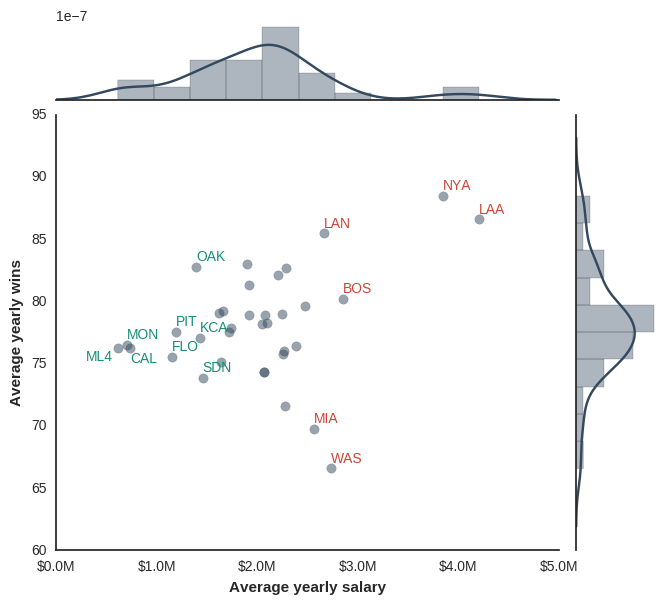

In [10]:
sns.set_style("white")
g = sns.jointplot(data=wins_vs_salary, x='salary', y='W', \
                  stat_func=None, s=45, alpha=0.5, color='#34495e', \
                  marginal_kws=dict(bins=10, kde=True), xlim=(0,5000000))
g.set_axis_labels("Average yearly salary","Average yearly wins", weight='bold')
g.fig.set_size_inches((7,6))
g.ax_marg_x.xaxis.set_major_formatter(formatter)

# Add data labels for top spenderes and least spenders and adjust annotation for overlapping labels
for t, x, y in zip(wins_vs_salary.index, wins_vs_salary.salary, wins_vs_salary.W):
    if x>2500000:
        g.ax_joint.annotate(s=t, xy=(x, y+0.5), color='#CB4335')
    elif t == 'CAL':
        g.ax_joint.annotate(s=t, xy=(x, y-1.2), color='#138D75')
    elif t == 'ML4':
        g.ax_joint.annotate(s=t, xy=(300000, y-1), color='#138D75')
    elif x<1500000:
        g.ax_joint.annotate(s=t, xy=(x, y+0.5), color='#138D75')

In [11]:
batting = read_csv('Batting.csv')
pitching = read_csv('Pitching.csv')
fielding = read_csv('Fielding.csv')

Batting.csv has 101332 rows and 22 columns
Pitching.csv has 44139 rows and 30 columns
Fielding.csv has 170526 rows and 18 columns


In [12]:
# Add salary information to palyer statistics
batting = batting.merge(salaries[['playerID','salary']], on='playerID', how='left')
pitching = pitching.merge(salaries[['playerID','salary']], on='playerID', how='left')
fielding = fielding.merge(salaries[['playerID','salary']], on='playerID', how='left')

In [13]:
def draw_clustermap(df, fmt=None):
    # Remove ordinal columns
    non_ordinal_cols = [col for col in df.columns if col not in ['yearID', 'Rank']]

    # Compute the correlation matrix
    corr = df[non_ordinal_cols].corr()
    
    # Draw a clustermap using correlation as a distance metric
    g = sns.clustermap(corr, cmap='Spectral', linewidths=.5, metric='correlation', annot=(fmt!=None), fmt=fmt)
    plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    plt.show()

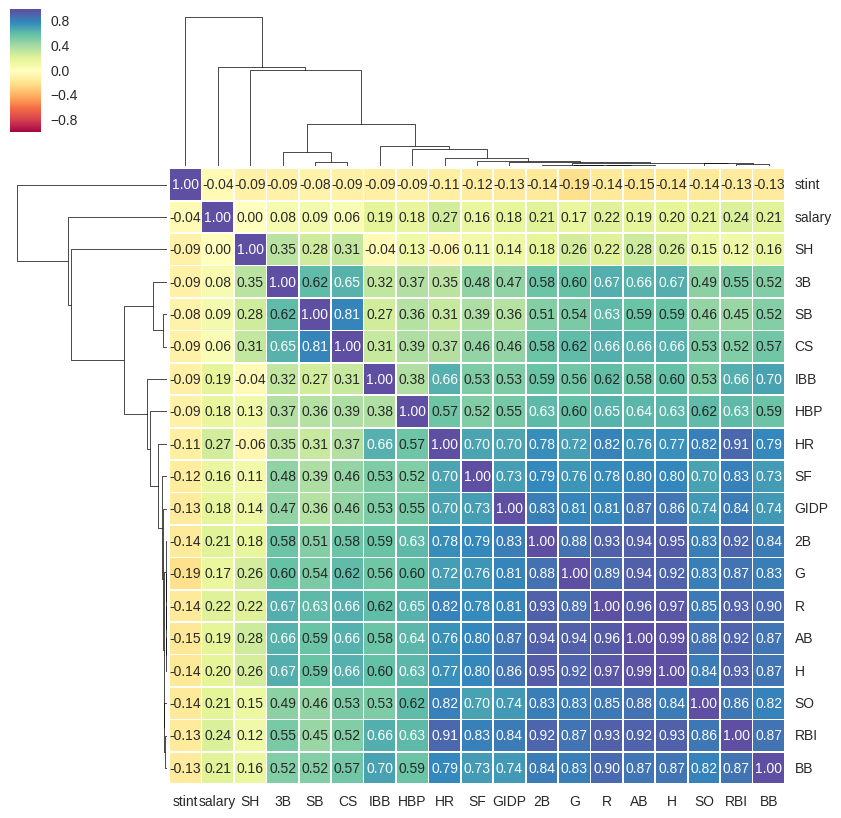

In [14]:
# Correlation clustermap of batting statistics
draw_clustermap(batting, '.2f')

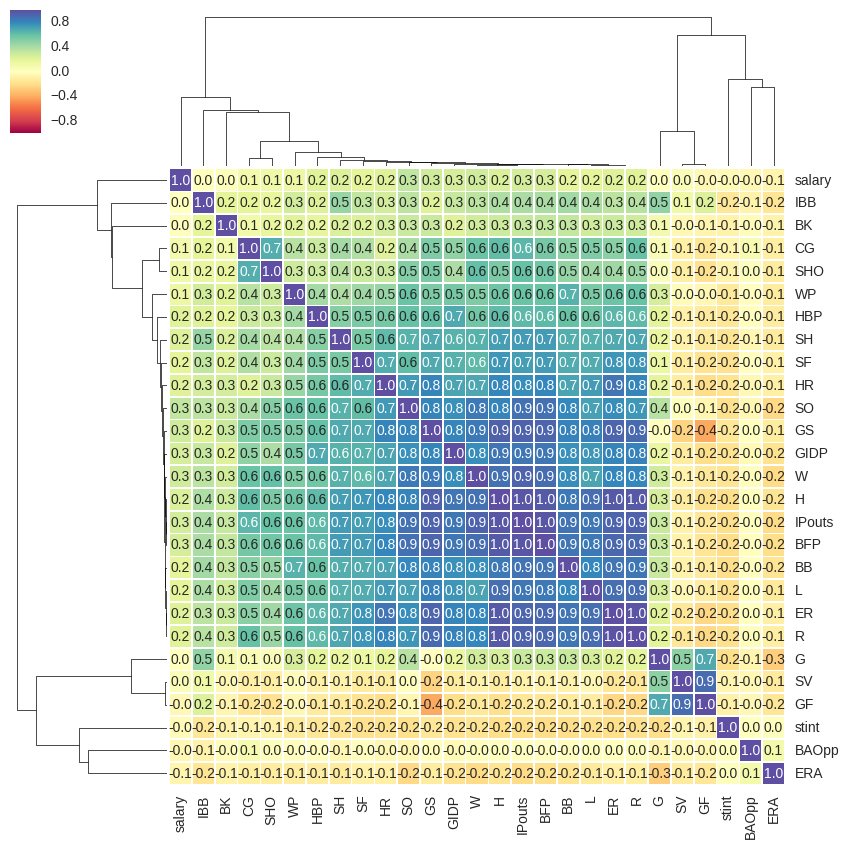

In [15]:
# Correlation clustermap of pitching statistics
draw_clustermap(pitching, '.1f')

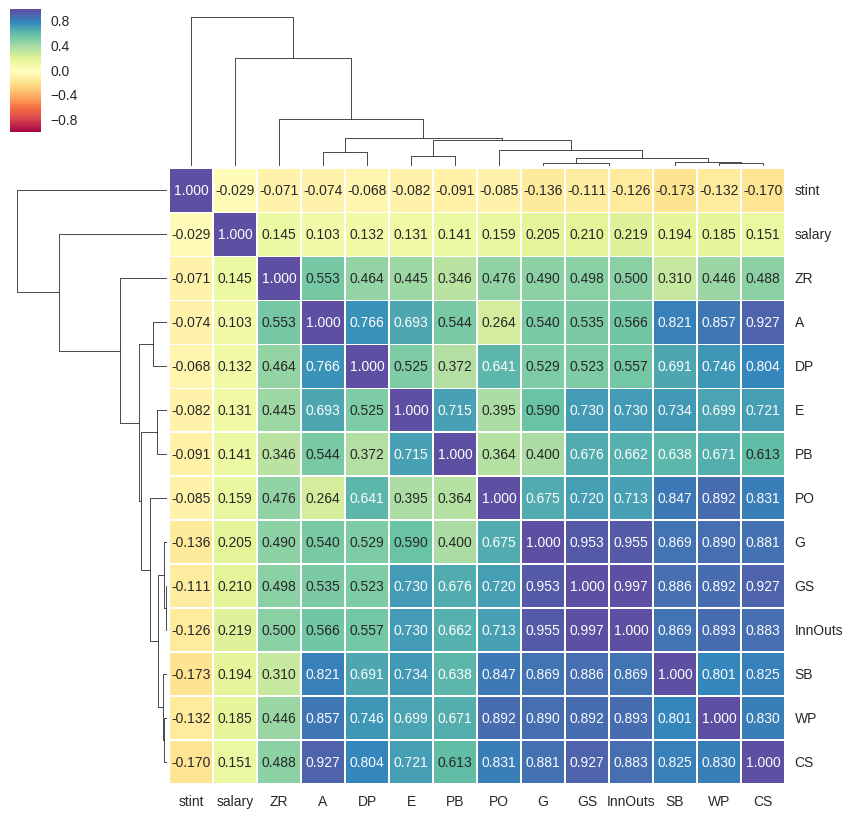

In [16]:
# Correlation clustermap of fielding statistics
draw_clustermap(fielding, '.3f')